# Assignment 1

# Part B: Analysing CSV Data

In [1]:
#Importing Necessary Libraries
from pyspark.sql.functions import col,udf,year,month,dayofweek,concat,lit
from pyspark.sql.types import DateType
from datetime import datetime
import matplotlib.pyplot as plt # For Drawing plots

## Step 01: Import pyspark and initialize Spark

In [2]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.mongodb.spark:mongo-spark-connector_2.11:2.4.0 pyspark-shell'
# create entry points to spark
from pyspark import SparkContext # Spark
from pyspark.sql import SparkSession # Spark SQL

# We add this line to avoid an error : "Cannot run multiple SparkContexts at once". 
# If there is an existing spark context, we will reuse it instead of creating a new context.
sc = SparkContext.getOrCreate()

# local[*]: run Spark locally with as many working processors as logical cores on your machine.
# In the field of `master`, we use a local server with as many working processors (or threads) as possible (i.e. `local[*]`). 
# If we want Spark to run locally with 'k' worker threads, we can specify as `local[k]`.
# The `appName` field is a name to be shown on the Sparking cluster UI. 

# If there is no existing spark context, we now create a new context
if (sc is None):
    sc = SparkContext(master="local[*]")
spark = SparkSession(sparkContext=sc)\
        .builder\
        .appName("Analyse Crime")\
        .config("spark.mongodb.input.uri", "mongodb://127.0.0.1/fit5202_db.assign1")\
        .config("spark.mongodb.output.uri", "mongodb://127.0.0.1/fit5202_db.assign1")\
        .getOrCreate()


## Step 02: Create Dataframe

In [3]:
crimeDF = spark.read.csv('Crime_Statistics_SA_2010_present.csv', header=True, inferSchema=True)
print("Total no of records in the dataFrame are",crimeDF.count())

Total no of records in the dataFrame are 727408


## Step 03: Write to Database

In [4]:
crimeDF.write.format("com.mongodb.spark.sql.DefaultSource").mode("overwrite").save()

## Step 04: Read from Database

In [5]:
crimeMongodbDF = spark.read.format("com.mongodb.spark.sql.DefaultSource").load()
crimeMongodbDF.printSchema()

root
 |-- Offence Count: integer (nullable = true)
 |-- Offence Level 1 Description: string (nullable = true)
 |-- Offence Level 2 Description: string (nullable = true)
 |-- Offence Level 3 Description: string (nullable = true)
 |-- Postcode - Incident: string (nullable = true)
 |-- Reported Date: string (nullable = true)
 |-- Suburb - Incident: string (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)



## Step 05: Calculate the statistics of numeric and string columns

Checking if there is any None values in offence count. If it is there then removing those values.

In [6]:
crimeMongodbDF.filter(crimeMongodbDF["Offence Count"].isNull()).count()

1

In [7]:
crimeMongodbDFNaFiltered = crimeMongodbDF.na.drop(subset=["Offence Count"])
crimeMongodbDFNaFiltered.filter(crimeMongodbDFNaFiltered["Offence Count"].isNull()).count()

0

similarly checking for reported date

In [8]:
crimeMongodbDFNaFiltered.filter(crimeMongodbDFNaFiltered["Reported Date"].isNull()).count()

0

### For Offence Count

### Count

In [9]:
crimeMongodbDFNaFiltered.select("Offence Count").count()

727407

### Mean

In [10]:
crimeMongodbDFNaFiltered.agg({"Offence Count": "avg"}).show()

+------------------+
|avg(Offence Count)|
+------------------+
|1.1715174585892079|
+------------------+



### Min

In [11]:
crimeMongodbDFNaFiltered.agg({"Offence Count": "min"}).show()

+------------------+
|min(Offence Count)|
+------------------+
|                 1|
+------------------+



### Max

In [12]:
crimeMongodbDFNaFiltered.agg({"Offence Count": "max"}).show()

+------------------+
|max(Offence Count)|
+------------------+
|                28|
+------------------+



### Standard Deviation

In [13]:
crimeMongodbDFNaFiltered.agg({"Offence Count": "std"}).show()

+---------------------+
|stddev(Offence Count)|
+---------------------+
|   0.5787050930378123|
+---------------------+



### For Reported Date

### Count

In [14]:
crimeMongodbDFNaFiltered.select("Reported Date").count()

727407

### Mean

In [15]:
crimeMongodbDFNaFiltered.agg({"Reported Date": "avg"}).show()

+------------------+
|avg(Reported Date)|
+------------------+
|              null|
+------------------+



### Min

In [16]:
crimeMongodbDFNaFiltered.agg({"Reported Date": "min"}).show()

+------------------+
|min(Reported Date)|
+------------------+
|         1/01/2011|
+------------------+



### Max

In [17]:
crimeMongodbDFNaFiltered.agg({"Reported Date": "max"}).show()

+------------------+
|max(Reported Date)|
+------------------+
|         9/12/2018|
+------------------+



### Standard Deviation

In [18]:
crimeMongodbDFNaFiltered.agg({"Reported Date": "std"}).show()

+---------------------+
|stddev(Reported Date)|
+---------------------+
|                 null|
+---------------------+



No I dont thing the min and max values of reported date are correct as it only compares the values lexiografically  since the column is of type string and not date. A date value which is lexiografically min or max need not be actually min or max values

### Step 06: Change the data type of a column

In [19]:
dateConversionFunction =  udf (lambda x: datetime.strptime(x, '%d/%m/%Y'), DateType())

In [20]:
crimeMongodb = crimeMongodbDFNaFiltered.withColumn('Reported Date', dateConversionFunction(col('Reported Date')))

In [21]:
crimeMongodb.printSchema()

root
 |-- Offence Count: integer (nullable = true)
 |-- Offence Level 1 Description: string (nullable = true)
 |-- Offence Level 2 Description: string (nullable = true)
 |-- Offence Level 3 Description: string (nullable = true)
 |-- Postcode - Incident: string (nullable = true)
 |-- Reported Date: date (nullable = true)
 |-- Suburb - Incident: string (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)



In [22]:
crimeMongodb.agg({"Reported Date": "max"}).show()

+------------------+
|max(Reported Date)|
+------------------+
|        2019-03-31|
+------------------+



In [23]:
crimeMongodb.agg({"Reported Date": "min"}).show()

+------------------+
|min(Reported Date)|
+------------------+
|        2010-07-01|
+------------------+



Here we can see that this min and max are the actual min and max values which is different from what we found out earlier when the date column was of type string

### Step 07: Preliminary data analysis

Write the code to answer the following analytical queries.
- How many level 2 offences are there? Display the list of level 2 offences.
- What is the number of offences against the person?
- How many serious criminal tresspasses with more than 1 offence count?
- What percentage of crimes are offences against the property?

Answers : 

In [24]:
level2Offences = crimeMongodb.select('Offence Level 2 Description').distinct()
print("The total no of level 2 offences are",level2Offences.count()," and They are : ")
level2Offences.show(truncate = False)

The total no of level 2 offences are 9  and They are : 
+------------------------------------+
|Offence Level 2 Description         |
+------------------------------------+
|ROBBERY AND RELATED OFFENCES        |
|PROPERTY DAMAGE AND ENVIRONMENTAL   |
|SEXUAL ASSAULT AND RELATED OFFENCES |
|HOMICIDE AND RELATED OFFENCES       |
|ACTS INTENDED TO CAUSE INJURY       |
|SERIOUS CRIMINAL TRESPASS           |
|OTHER OFFENCES AGAINST THE PERSON   |
|FRAUD DECEPTION AND RELATED OFFENCES|
|THEFT AND RELATED OFFENCES          |
+------------------------------------+



In [25]:
offencesAgainstPerson = crimeMongodb.filter(crimeMongodb['Offence Level 1 Description'] == "OFFENCES AGAINST THE PERSON")
print("The Total No of Offences Against the person is",offencesAgainstPerson.count())

The Total No of Offences Against the person is 156062


In [26]:
temp = crimeMongodb.filter(crimeMongodb['Offence Level 2 Description'] == "SERIOUS CRIMINAL TRESPASS")
tresspassesWithCountMoreThan1 = temp.filter(temp['Offence Count'] >1)
print("The No of serious criminal tresspasses with offence count more than 1 is",tresspassesWithCountMoreThan1.count())

The No of serious criminal tresspasses with offence count more than 1 is 8579


In [27]:
totalCount = crimeMongodb.count()
offenceAgainstPropCount = crimeMongodb.filter(crimeMongodb['Offence Level 1 Description'] == "OFFENCES AGAINST PROPERTY").count()
print("About",str(round((offenceAgainstPropCount/totalCount)*100,2))+"% of crimes are offences against property")

About 78.55% of crimes are offences against property


## Step 08: Exploratory data analysis

- Find the number of crimes per year. Plot the graph and explain your understanding
of the graph.
- Find the number of crimes per month. Plot the graph and explain your
understanding of the graph.
- Where do most crimes take place? Find the top 20 suburbs (which would also
display postcode for e.g. Caulfield-3162 )?. Plot the graph and explain your
understanding of the graph.
- Find the number of serious criminal trespasses by day and month. Plot a graph and
explain your understanding of the graph.

In [28]:
groupedByYear = crimeMongodb.select(year('Reported Date').alias('year'),'Offence Count').groupBy('year').sum('Offence Count').collect()

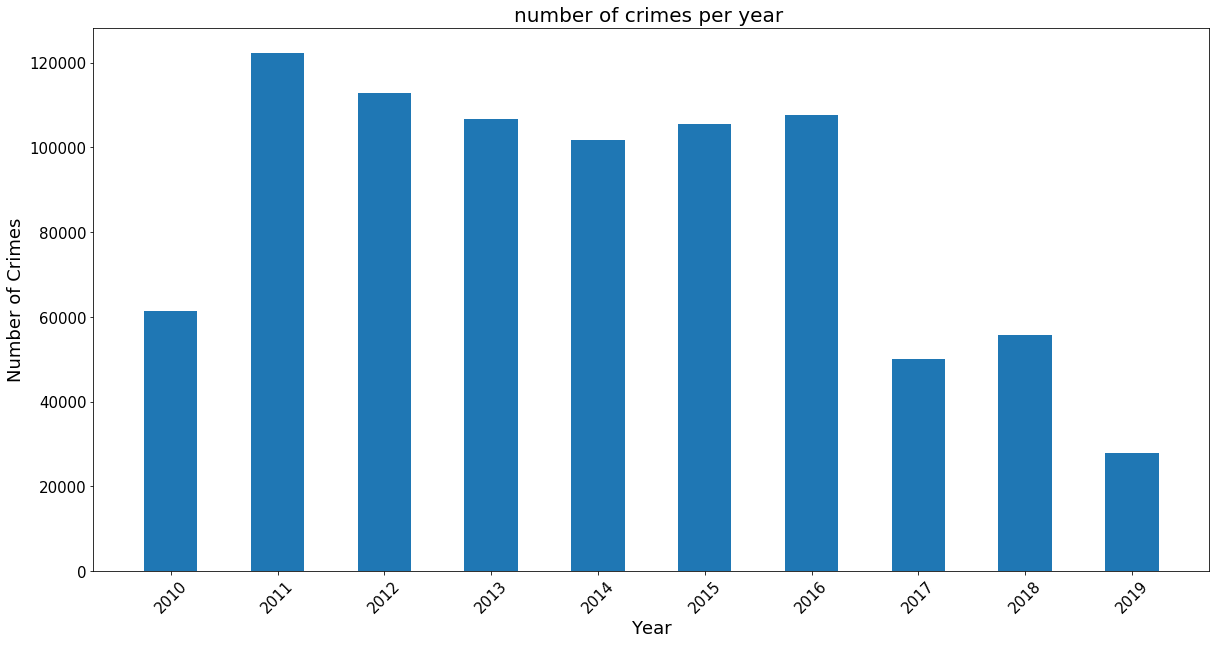

In [29]:
groupedYear = [row['year'] for row in groupedByYear]
offenceCount = [row['sum(Offence Count)'] for row in groupedByYear]

plt.figure(figsize = (20,10))
plt.bar(groupedYear, offenceCount, 0.5, align='center', color='C0')
plt.yticks(fontsize=15)
plt.xticks(groupedYear,rotation = 45, fontsize = 15)
plt.xlabel('Year',fontsize=18)
plt.ylabel('Number of Crimes',fontsize=18)
plt.title('number of crimes per year ',fontsize=20)

plt.show()

From the figure we can see that the max number of crimes was on year 2011 and least no of crimes was on 2019. From the figure we can see that from 2010 to 2011 there is a major hike in no of crimes the from 2011 till 2014 we can see that there is a slight decrease in no of crimes. Then from 2014 till 2016 we can see that there is a slight increase in the no of crimes after 2016 then there is a major decrease in  no of crimes in year 2017

In [30]:
groupedByMonth = crimeMongodb.select(month('Reported Date').alias('month'),'Offence Count').groupBy('month').sum('Offence Count').orderBy('month').collect()

In [31]:
groupedByMonth

[Row(month=1, sum(Offence Count)=77516),
 Row(month=2, sum(Offence Count)=70429),
 Row(month=3, sum(Offence Count)=74931),
 Row(month=4, sum(Offence Count)=60037),
 Row(month=5, sum(Offence Count)=64246),
 Row(month=6, sum(Offence Count)=60687),
 Row(month=7, sum(Offence Count)=70954),
 Row(month=8, sum(Offence Count)=72839),
 Row(month=9, sum(Offence Count)=72595),
 Row(month=10, sum(Offence Count)=77153),
 Row(month=11, sum(Offence Count)=75191),
 Row(month=12, sum(Offence Count)=75592)]

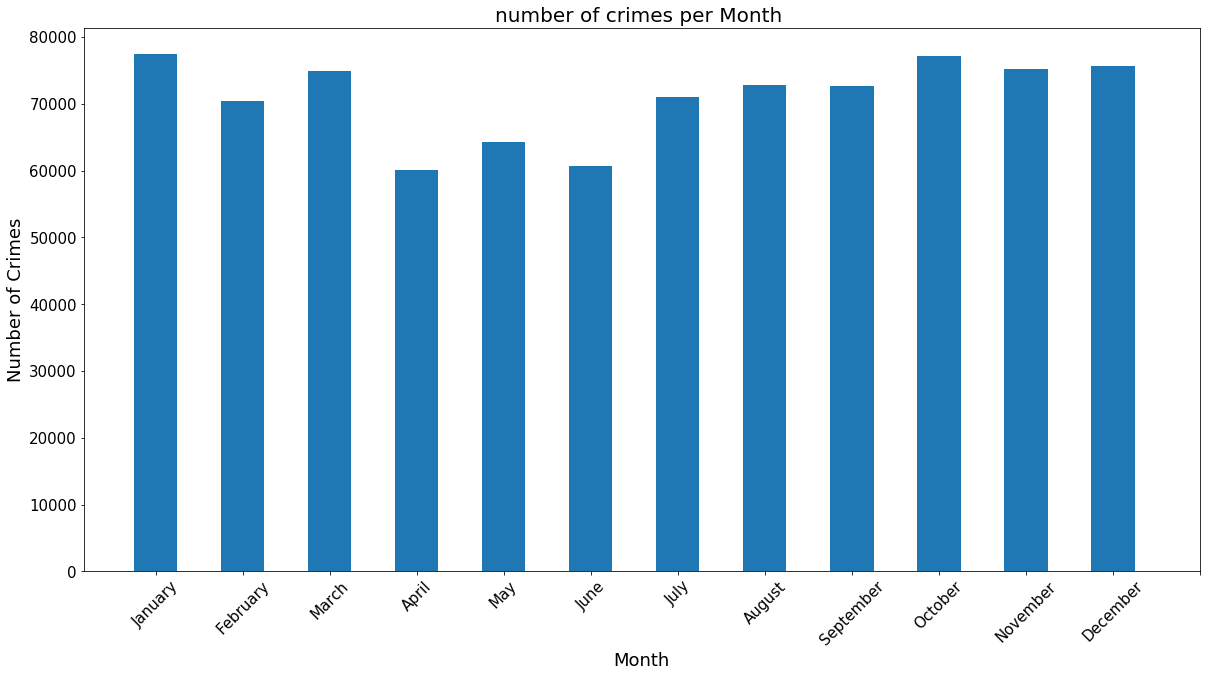

In [32]:
groupedMonth = [row['month'] for row in groupedByMonth]
offenceCount = [row['sum(Offence Count)'] for row in groupedByMonth]

xTickpos = [x+1 for x in range(len(groupedMonth)+1)]
xTickName = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'] 
plt.figure(figsize = (20,10))
plt.bar(groupedMonth, offenceCount, 0.5, align='center', color='C0')
plt.yticks(fontsize=15)
plt.xticks(xTickpos,xTickName,rotation = 45, fontsize = 15)
plt.xlabel('Month',fontsize=18)
plt.ylabel('Number of Crimes',fontsize=18)
plt.title('number of crimes per Month ',fontsize=20)

plt.show()

Here from the plot we can see that the maximum number of crimes is on January Followed by October and minumum no of crimes is on April followed by june. We can also see that the no of crimes between april to june is comparetively less compared to the rest of the months

In [33]:
#Concating suburb and postcode columns
crimeMongodbDFSuburb = crimeMongodbDF.withColumn('Suburb-postcode', 
                    concat(col('Suburb - Incident'),lit('-'), col('Postcode - Incident')))

In [34]:
groupedBySuburb = crimeMongodbDFSuburb.select('Suburb-postcode','Offence Count').groupBy('Suburb-postcode').sum('Offence Count').sort('sum(Offence Count)', ascending=False).take(20)
groupedBySuburb

[Row(Suburb-postcode='ADELAIDE-5000', sum(Offence Count)=46701),
 Row(Suburb-postcode='PORT AUGUSTA-5700', sum(Offence Count)=13711),
 Row(Suburb-postcode='MOUNT GAMBIER-5290', sum(Offence Count)=13709),
 Row(Suburb-postcode='MURRAY BRIDGE-5253', sum(Offence Count)=12919),
 Row(Suburb-postcode='MORPHETT VALE-5162', sum(Offence Count)=12569),
 Row(Suburb-postcode='SALISBURY-5108', sum(Offence Count)=10806),
 Row(Suburb-postcode='PORT LINCOLN-5606', sum(Offence Count)=10779),
 Row(Suburb-postcode='ELIZABETH-5112', sum(Offence Count)=10731),
 Row(Suburb-postcode='NOT DISCLOSED-NOT DISCLOSED', sum(Offence Count)=9375),
 Row(Suburb-postcode='DAVOREN PARK-5113', sum(Offence Count)=8082),
 Row(Suburb-postcode='PARAFIELD GARDENS-5107', sum(Offence Count)=8040),
 Row(Suburb-postcode='OAKLANDS PARK-5046', sum(Offence Count)=7792),
 Row(Suburb-postcode='PARALOWIE-5108', sum(Offence Count)=7261),
 Row(Suburb-postcode='PROSPECT-5082', sum(Offence Count)=7234),
 Row(Suburb-postcode='PORT PIRIE-5540'

Here we can see a column with name not disclosed - not disclosed

In [35]:
crimeMongodbDFSuburb.filter(crimeMongodbDFSuburb["Postcode - Incident"] == 'NOT DISCLOSED').count()

8939

We can see that there are lot of rows with value not disclosed so lets take the top 21 and just remove not disclosed value to get the top 20

In [36]:
groupedBySuburb21 = crimeMongodbDFSuburb.select('Suburb-postcode','Offence Count').groupBy('Suburb-postcode').sum('Offence Count').sort('sum(Offence Count)', ascending=False).take(21)

In [37]:
groupedBySuburb = [x for x in groupedBySuburb21 if x['Suburb-postcode'] !='NOT DISCLOSED-NOT DISCLOSED']
groupedBySuburb

[Row(Suburb-postcode='ADELAIDE-5000', sum(Offence Count)=46701),
 Row(Suburb-postcode='PORT AUGUSTA-5700', sum(Offence Count)=13711),
 Row(Suburb-postcode='MOUNT GAMBIER-5290', sum(Offence Count)=13709),
 Row(Suburb-postcode='MURRAY BRIDGE-5253', sum(Offence Count)=12919),
 Row(Suburb-postcode='MORPHETT VALE-5162', sum(Offence Count)=12569),
 Row(Suburb-postcode='SALISBURY-5108', sum(Offence Count)=10806),
 Row(Suburb-postcode='PORT LINCOLN-5606', sum(Offence Count)=10779),
 Row(Suburb-postcode='ELIZABETH-5112', sum(Offence Count)=10731),
 Row(Suburb-postcode='DAVOREN PARK-5113', sum(Offence Count)=8082),
 Row(Suburb-postcode='PARAFIELD GARDENS-5107', sum(Offence Count)=8040),
 Row(Suburb-postcode='OAKLANDS PARK-5046', sum(Offence Count)=7792),
 Row(Suburb-postcode='PARALOWIE-5108', sum(Offence Count)=7261),
 Row(Suburb-postcode='PROSPECT-5082', sum(Offence Count)=7234),
 Row(Suburb-postcode='PORT PIRIE-5540', sum(Offence Count)=7155),
 Row(Suburb-postcode='MODBURY-5092', sum(Offence C

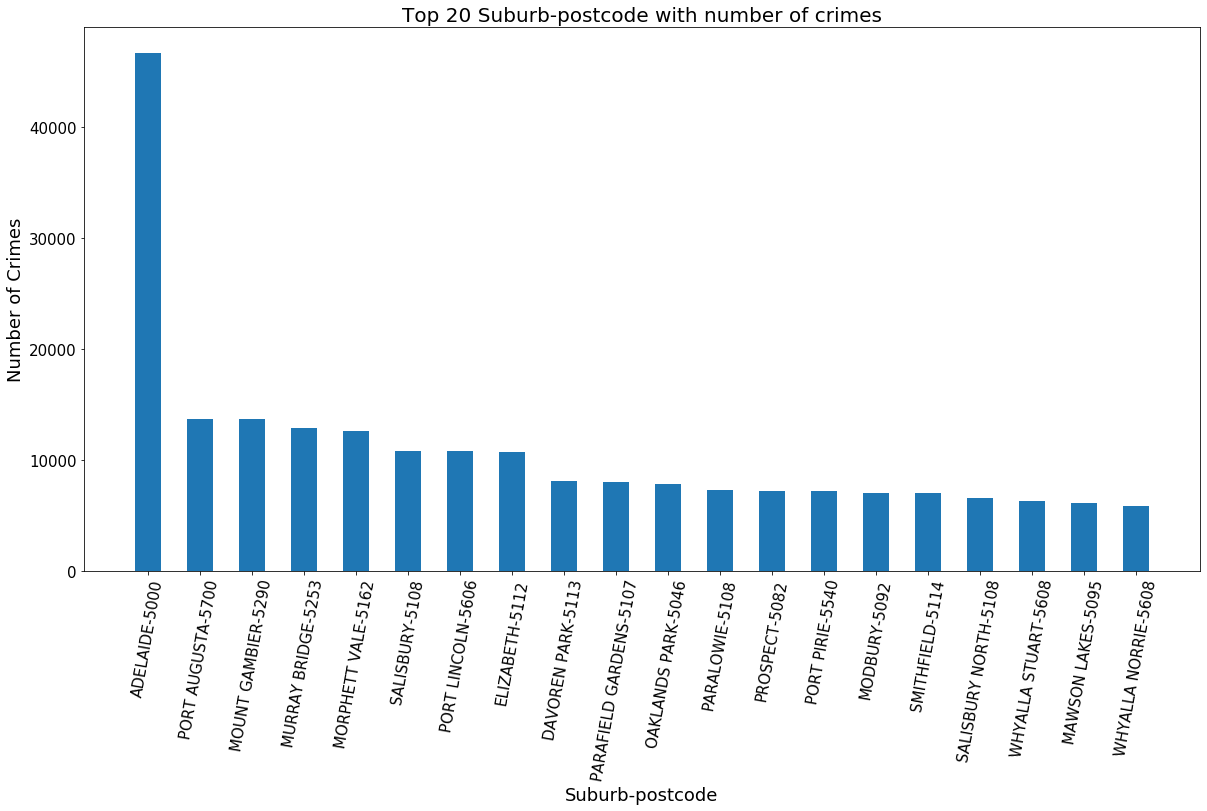

In [45]:
groupedSuburb = [row['Suburb-postcode'] for row in groupedBySuburb]
offenceCount = [row['sum(Offence Count)'] for row in groupedBySuburb]

plt.figure(figsize = (20,10))
plt.bar(groupedSuburb, offenceCount, 0.5, align='center', color='C0')
plt.yticks(fontsize=15)
plt.xticks(groupedSuburb,rotation = 80, fontsize = 15)
plt.xlabel('Suburb-postcode',fontsize=18)
plt.ylabel('Number of Crimes',fontsize=18)
plt.title('Top 20 Suburb-postcode with number of crimes',fontsize=20)

plt.show()

Here we can see that the maximum no of crimes are in adelaide - 5000 with approx value of about 3 times of that of the second place.The rest of the values looks more evenly distributed. Because of this big difference there is a chance that it might be an outlier.

In [39]:
groupedByDayMonth = crimeMongodb.select(dayofweek('Reported Date').alias('day'),month('Reported Date').alias('month'),'Offence Count').groupBy('day','month').sum('Offence Count').orderBy('month','day').collect()

In [40]:
days = ['','Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']
monthName = ['','January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

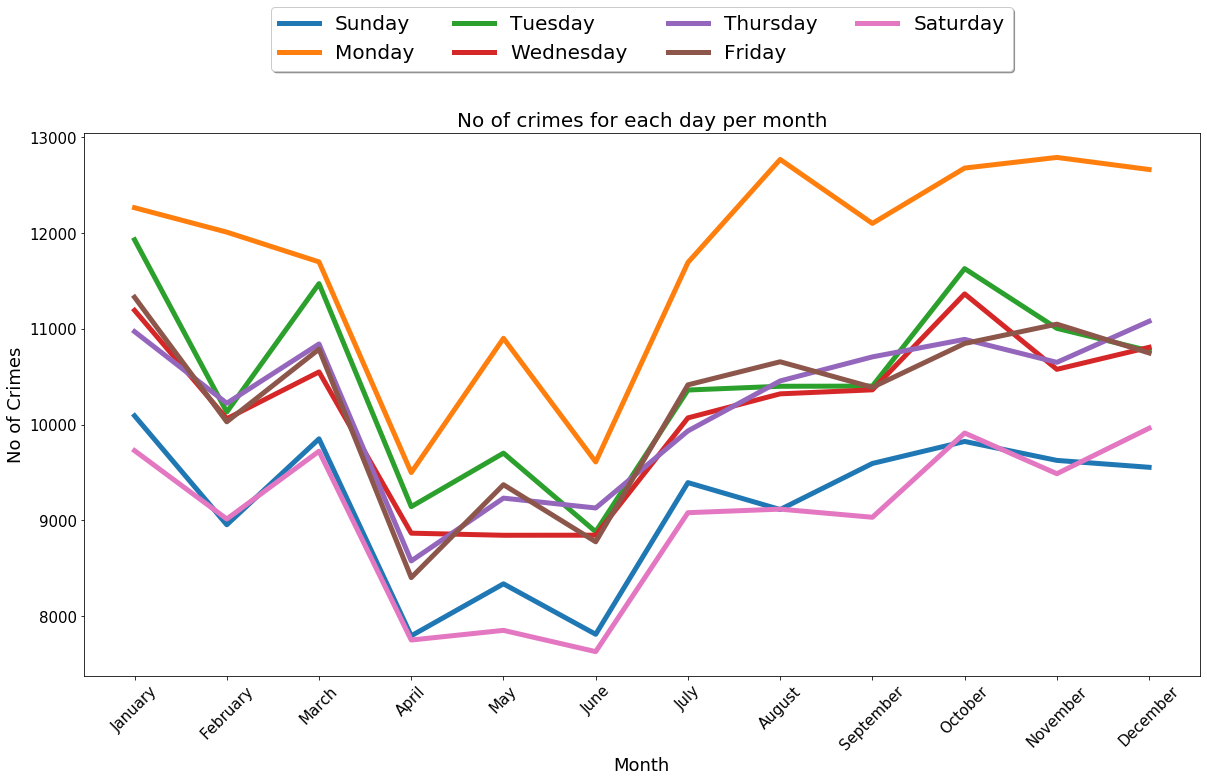

In [41]:
def PlotLinesBasedOnMonth(l,day):
    monthVal = [monthName[x['month']] for x in l]
    offenceCt = [x['sum(Offence Count)'] for x in l] 
    plt.plot(monthVal, offenceCt, label = day, linewidth=5.0)
    return

plt.figure(figsize = (20,10))
l=[]
for i in range(1,8):
    l = [x for x in groupedByDayMonth if x['day'] == i]
    day = days[i]
    PlotLinesBasedOnMonth(l,day)

monthVal = [monthName[x['month']] for x in l]
    
plt.yticks(fontsize=15)
plt.xticks(monthVal,rotation = 45, fontsize = 15)
plt.xlabel('Month',fontsize=18)
plt.ylabel('No of Crimes',fontsize=18)
plt.title('No of crimes for each day per month',fontsize=20)
plt.legend(loc= 'upper center', ncol = 4, fancybox = True, shadow = True, bbox_to_anchor = (0.5, 1.25), fontsize = 20)
plt.show()

Here we can see that maximum no of crimes are done on monday out of all Days. Max no of crime is done on monday on the month november. The no of crimes on the weekends that is saturday and sunday is comparetively low compared to that of the weekdays. Also we can see that generally the no of crimes is low on the months between april to june compared to that of the rest of the months. The least no of crimes are on saturdays on month June